**Brian Blaylock**  
**May 16, 2019**

# **Fig. 4.** Case Events: Maps

![](./figs/Fig-04_Cases-Map.png)

> FIG. 4. Left) HRRR analysis (F00) simulated composite reflectivity according to scale; Center) HRRR lightning threat greater than 0.04 flashes km-2 5-min-1 forecasted areas for F01 (red), F06 (blue), F12 (green), and F18 (orange); Right) GLM flash centroids (yellow) and GLM events binary field (dark blue) for the previous hour ending at the following times: a) 0200 UTC 16 May 2018 during the Mallard fire in Texas, b) 2100 UTC 5 July 2018 during the Lake Christine fire in Colorado, c) 0600 UTC 17 July 2018 during a thunderstorm in Utah. White circles denote location of the Mallard and Lake Christine fires in a) and b).

1. **Lake Christine Fire**: `21:00 UTC 5 July 2018`
    - A convective envent recommended by Robert Zeil. The fire started on 3 July 2018, cause by humans, and spread rapidly on 4 July 2018 due to thunderstom outflow or a gravity wave. Fuels were extreamly dry and RH was in single digits. On 4 July 2018, approximatly 1793 residents from 664 homes were evacuated. Three homes were destroyed. By 7 July, almost half of the evacuees returned to their homes.
2. **Mallard Fire** `23:00 UTC 15 May 2018`
    - Texas, was forecasted well.  
3. **Utah Thunderstorm** `06:00 UTC 17 July 2018`
    - Thunderstorm in Utah was poorly forecasted but saw lots of lightning.

## Research Questions
1. How well did the HRRR model forecast the thunderstorms for the area.
2. Did the GLM lightning flashes provide any warning? 
3. From the initial GLM flashes, what was the predicted risk of continued lightning and convective activity for the area?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from datetime import datetime, timedelta
import multiprocessing
import os

import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/')
from BB_HRRR.HRRR_Pando import get_hrrr_variable, get_hrrr_latlon
from BB_GOES.get_GOES import get_GOES_nearesttime
from BB_GOES.get_GLM import get_GLM_file_nearesttime, accumulate_GLM_FAST, filter_by_HRRR
from BB_datetimes.range import range_dates
from BB_maps.my_basemap import draw_centermap, draw_HRRR_map
from BB_cmap.reflectivity_cmap import reflect_ncdc

from BB_HRRR.GLM_and_HRRR.GLM_events_HRRR import get_GLM_HRRR_contingency_stats

from fires_list import get_fire

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [7.8, 7.2]
mpl.rcParams['figure.titlesize'] = 10
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['xtick.labelsize'] = 7
mpl.rcParams['ytick.labelsize'] = 7
mpl.rcParams['axes.labelsize'] = 7
mpl.rcParams['axes.titlesize'] = 10
mpl.rcParams['lines.linewidth'] = 1.25
mpl.rcParams['grid.linewidth'] = .25
#mpl.rcParams['figure.subplot.wspace'] = 0.03
#mpl.rcParams['figure.subplot.hspace'] = 0.00
mpl.rcParams['legend.fontsize'] = 7
mpl.rcParams['legend.framealpha'] = .75
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.dpi'] = 600

Create HRRR map.
loaded /uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_maps/saved_map_objects/HRRR_lcc_c_2000.npy map from file
Forecasts [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
Generate domains and masks.
HRRR Area in meters squared: 16811840278558.668
West Area in meters squared: 4034896806752.7593
Central Area in meters squared: 4034896806752.766
East Area in meters squared: 4034896806752.762
Utah Area in meters squared: 219973261639.39685
Colorado Area in meters squared: 269906899003.7569
Texas Area in meters squared: 688270731111.2987
Florida Area in meters squared: 149996892486.02234
dict_keys(['HRRR', 'West', 'Central', 'East', 'Utah', 'Colorado', 'Texas', 'Florida'])


In [2]:
def get_GLM_flashes(DATE, GOES=16, verbose=False):
    # GLM Files for the hour
    GLM_files = get_GOES_nearesttime(DATE-timedelta(minutes=30),
                                     product='GLM', satellite=GOES, window=30, verbose=verbose)

    # GLM flash data from those files
    GLM_flash = accumulate_GLM_FAST(GLM_files, data_type='flash', verbose=verbose)

    # Boolean for flashes inside HRRR domain
    GLM_in_HRRR = filter_by_HRRR(GLM_flash['latitude'], GLM_flash['longitude'], lat, lon, mHRRR) 

    # Rewrite lightning flashes for only in HRRR domian
    GLM_flash['longitude'] = GLM_flash['longitude'][GLM_in_HRRR]
    GLM_flash['latitude'] = GLM_flash['latitude'][GLM_in_HRRR]
    return GLM_flash

In [3]:
def add_fire_point(ax, arrow=True):
    
    bbox = {'facecolor':'white',
        'alpha':0.90,
        'pad':.4,
        'edgecolor':'none',
        'boxstyle':'round4'}
    
    arrowprop = {'facecolor':'black',
                 'shrink':.04,
                 'width':1.5,
                 'headwidth':5,
                 }
       
    if arrow:
        plt.annotate(event+' fire', xy=(LON, LAT), xytext=(.9, .9),
                     xycoords='data', textcoords='axes fraction', zorder=100, ha='right',
                     arrowprops=arrowprop, bbox=bbox)
    
    m.scatter(LON, LAT, latlon=True, facecolors='none', edgecolors='w',
              s=10, zorder=99)

In [4]:
def plot_refc(ax, DATE, var='REFC:entire'):
    plt.sca(ax)
    Hrefc = get_hrrr_variable(DATE, var, verbose=False)
    pr = m.contourf(lon, lat, Hrefc['value'].data, latlon=True, levels=range(0,80,5),
                    cmap=c['cmap'], vmax=c['vmax'], vmin=c['vmin'])
    m.drawstates(linewidth=lw)
    m.drawcountries(linewidth=lw)
    #m.drawcounties()
    m.arcgisimage(service='World_Shaded_Relief', xpixels=xpixels)
    if event in ['Mallard', 'Lake Christine']:
        add_fire_point(ax, arrow=True)
    return pr

In [5]:
def plot_ltng(ax, DATE, binary):
    plt.sca(ax)
    alpha = .3
    for fxx, color in zip([1, 6, 12, 18], ['tab:red', 'tab:blue', 'tab:green', 'tab:orange']):
        m.contour(lon, lat, binary['Forecast Binary'][fxx-1],
                  levels=1, colors=color, zorder=np.abs(fxx-17)+100)
        m.contourf(lon, lat, np.array(binary['Forecast Binary'][fxx-1], dtype=int),
                   levels=np.arange(.8,1.2,.2), colors=[color], alpha=alpha, zorder=np.abs(fxx-17)+50)
    m.drawstates(linewidth=lw)
    m.drawcountries(linewidth=lw)
    #m.drawcounties()
    m.arcgisimage(service='World_Shaded_Relief', xpixels=xpixels)
    if event in ['Mallard', 'Lake Christine']:
        add_fire_point(ax, arrow=False)

In [6]:
def plot_glm(ax, DATE, binary, GOES17=False, verbose=False):
    plt.sca(ax)
    
    if GOES17:
        stats17 = get_GLM_HRRR_contingency_stats(DATE, GOES=17, verbose=verbose)
        GLM_binary = np.ma.array(stats17['Observed Binary'], mask=stats17['Observed Binary']==0)
        m.pcolormesh(lon, lat, GLM_binary, cmap='Reds_r', latlon=True)
        m.contour(lon, lat, stats17['Observed Binary'], latlon=True, levels=[0,1],
                  colors='r', linestyles='--', linewidths=.75, zorder=100)
        GLM_flash = get_GLM_flashes(DATE, GOES=17, verbose=verbose)
        m.scatter(GLM_flash['longitude'], GLM_flash['latitude'], edgecolor='magenta',
                  marker='o', facecolor='none', s=.5, zorder=100, linewidth=.35)
    
    # GOES-16 Flashes
    GLM_flash = get_GLM_flashes(DATE)
    GLM_binary = np.ma.array(binary['Observed Binary'], mask=binary['Observed Binary']==0)
    m.pcolormesh(lon, lat, GLM_binary, cmap='Blues_r', latlon=True)
    m.scatter(GLM_flash['longitude'], GLM_flash['latitude'], c='gold', marker='.', s=1)
    m.drawstates(linewidth=lw)
    m.drawcountries(linewidth=lw)
    #m.drawcounties()
    m.arcgisimage(service='World_Shaded_Relief', xpixels=xpixels)    
    if FIRE['name'] in ['Mallard', 'Lake Christine']:
        add_fire_point(ax, arrow=False)

In [7]:
# Load some things I need...
c = reflect_ncdc()
lat, lon = get_hrrr_latlon(DICT=False)
mHRRR = draw_HRRR_map()
xpixels = 1000
lw = .8  # linewidth used for state boundaries
events = ['Mallard', 'Lake Christine', 'July Storm']

loaded /uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_maps/saved_map_objects/HRRR_lcc_i_2000.npy map from file


In [8]:
for event in events:
    FIRE = get_fire(event)
    print('%s %s' % (event, FIRE['event']))

Mallard 2018-05-16 02:00:00
Lake Christine 2018-07-05 21:00:00
July Storm 2018-07-17 06:00:00


In [9]:
# Map objects for each state: [(map center in lat/lon), (map size in degrees)]
Utah = [(39.5, -111.6), (3., 3.)]
Colorado = [(39.1, -105.55), (3.75, 3.75)]
Texas = [(33., -100.), (3.85, 3.85)]

mUtah = draw_centermap(center=Utah[0], size=Utah[1])
mColorado = draw_centermap(center=Colorado[0], size=Colorado[1])
mTexas = draw_centermap(center=Texas[0], size=Texas[1])

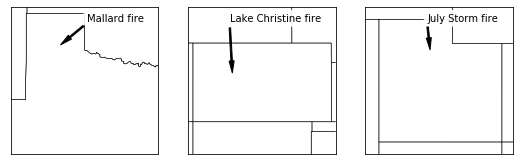

In [10]:
fig, axes = plt.subplots(1,3, figsize=(9,3))

for m, ax, event in zip([mTexas, mColorado, mUtah], axes, events):
    FIRE = get_fire(event)
    DATE = FIRE['event']
    LON = FIRE['longitude']
    LAT = FIRE['latitude']
    plt.sca(ax)
    m.drawstates()
    add_fire_point(ax)

>>> get_GLM_HRRR_contingency_stats: 2018-05-16 02:00:00
>>Load binary stats from file /uufs/chpc.utah.edu/common/home/horel-group8/blaylock/GLM-HRRR_LTNG_binary//HRRR-GLM-Binary_2018-05-16_0200.npy
Requested 2018-05-16 01:30:00	satellite: GOES-16	Product: GLM
-->> Accumulate GLM FAST MP: 90.0%Fishished: Mallard
>>> get_GLM_HRRR_contingency_stats: 2018-07-05 21:00:00
>>Load binary stats from file /uufs/chpc.utah.edu/common/home/horel-group8/blaylock/GLM-HRRR_LTNG_binary//HRRR-GLM-Binary_2018-07-05_2100.npy
Requested 2018-07-05 20:30:00	satellite: GOES-16	Product: GLM
Fishished: Lake Christine
>>> get_GLM_HRRR_contingency_stats: 2018-07-17 06:00:00
>>Load binary stats from file /uufs/chpc.utah.edu/common/home/horel-group8/blaylock/GLM-HRRR_LTNG_binary//HRRR-GLM-Binary_2018-07-17_0600.npy
Requested 2018-07-17 05:30:00	satellite: GOES-16	Product: GLM
-->> Accumulate GLM FAST MP: 45.0%Fishished: July Storm


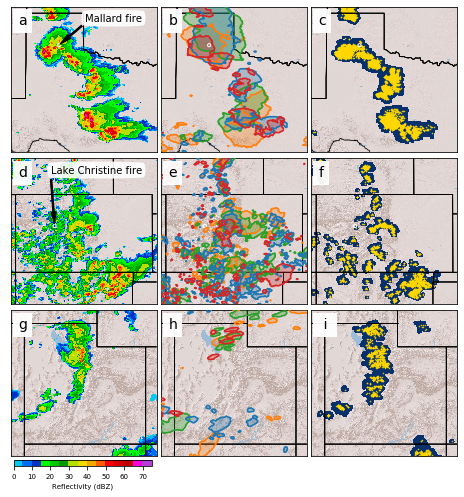

In [15]:
fig, axes = plt.subplots(3,3, figsize=[8, 8.7])
labels = [['a', 'b', 'c'],['d', 'e', 'f'],['g', 'h', ' i ']]
for ax, event, label, m in zip(axes, events, labels, [mTexas, mColorado, mUtah]):
    FIRE = get_fire(event)
    DATE = FIRE['event']
    LON = FIRE['longitude']
    LAT = FIRE['latitude']
    
    for a in ax:
        plt.sca(a)
        m.drawstates()
        
    binary = get_GLM_HRRR_contingency_stats(DATE)
    
    # Left Figure: HRRR F00 Simulated Reflectivity
    pr = plot_refc(ax[0], DATE)
    
    # Center Figure: Select HRRR LTNG Forecasts
    plot_ltng(ax[1], DATE, binary)
    
    # Right Figure: GLM Events and Flashes
    plot_glm(ax[2], DATE, binary)
    
    print("Fishished:", event)
    
    # figure labels
    bbox = {'facecolor':'white',
            'alpha':0.95,
            'pad':5,
            'edgecolor':'none'}
    for aa, lab in zip(ax, label):
        aa.text(0.05,.95, lab, bbox=bbox, va='top', ha='left',
                fontsize=14, transform=aa.transAxes, zorder=1000)
    
# Colorbar (lost of custome tweeking for different figure sizes, ugh!)
fig.subplots_adjust(bottom=0.01)
cbar_ax = fig.add_axes([0.13, 0.07, 0.24, 0.01]) # [left-right, up-down, width, height]
fig.colorbar(pr, cax=cbar_ax, orientation='horizontal', label='Reflectivity (dBZ)')

fig.subplots_adjust(hspace=-.37, wspace=0.03)

plt.savefig('./figs/Fig-04_Cases-Map')

## Not Shown: Observed Reflectivity from NEXRAD Radar
Radar mosaic image from the Iowa Environmental Mesonet.     
Data Source: https://mesonet.agron.iastate.edu/docs/nexrad_composites/

In [39]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from BB_maps.my_cartopy import add_NEXRAD, extent_centermap

# From: https://stackoverflow.com/questions/37423997/cartopy-shaded-relief
# NOTE: Zooming only works with Mercator projection
from cartopy.io.img_tiles import GoogleTiles
class ShadedReliefESRI(GoogleTiles):
    # shaded relief
    def _image_url(self, tile):
        x, y, z = tile
        url = ('https://server.arcgisonline.com/ArcGIS/rest/services/' \
               'World_Shaded_Relief/MapServer/tile/{z}/{y}/{x}.jpg').format(
               z=z, y=y, x=x)
        return url

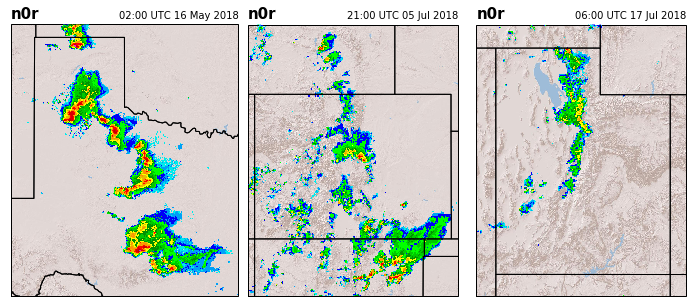

In [40]:
fig = plt.figure(figsize=(15, 5))

version = 'n0r'

for event, mm, i in zip(events, [Texas, Colorado, Utah], range(3)):
    FIRE = get_fire(event)
    DATE = FIRE['event']
    LON = FIRE['longitude']
    LAT = FIRE['latitude']

    ax = fig.add_subplot(1, len(events), i+1, projection=ShadedReliefESRI().crs)
    ax.add_feature(cfeature.STATES.with_scale('10m'), zorder=11)
                
    ax.add_image(ShadedReliefESRI(), 8)
    
    add_NEXRAD(ax, DATE, version=version)
    
    extent_centermap(ax, mm[0], size=mm[1])
        
    ax.set_title('%s' % DATE.strftime('%H:%M UTC %d %b %Y'), loc='right')
    ax.set_title(version, loc='left', fontweight='bold', fontsize=15)
    
fig.subplots_adjust(wspace=-.4)

plt.savefig('./figs/not_shown_NEXRAD-events_%s' % version)

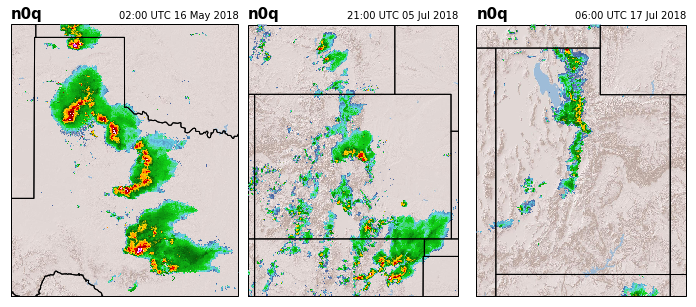

In [41]:
fig = plt.figure(figsize=(15, 5))

version = 'n0q'

for event, mm, i in zip(events, [Texas, Colorado, Utah], range(3)):
    FIRE = get_fire(event)
    DATE = FIRE['event']
    LON = FIRE['longitude']
    LAT = FIRE['latitude']
    
    ax = fig.add_subplot(1, len(events), i+1, projection=ShadedReliefESRI().crs)
    ax.add_feature(cfeature.STATES.with_scale('10m'), zorder=11)
                
    ax.add_image(ShadedReliefESRI(), 8)
    
    add_NEXRAD(ax, DATE, version=version)
    
    extent_centermap(ax, mm[0], size=mm[1])
    
    ax.set_title('%s' % DATE.strftime('%H:%M UTC %d %b %Y'), loc='right')
    ax.set_title(version, loc='left', fontweight='bold', fontsize=15)

fig.subplots_adjust(wspace=-.4)
    
plt.savefig('./figs/not_shown_NEXRAD-events_%s' % version)

-1


>>> get_GLM_HRRR_contingency_stats: 2018-05-15 20:00:00
>>Load binary stats from file /uufs/chpc.utah.edu/common/home/horel-group8/blaylock/GLM-HRRR_LTNG_binary//HRRR-GLM-Binary_2018-05-15_2000.npy


/uufs/chpc.utah.edu/common/home/u0553130/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


Requested 2018-05-15 19:30:00	satellite: GOES-16	Product: GLM
-->> Accumulate GLM FAST MP: 40.0%Fishished: Mallard
>>> get_GLM_HRRR_contingency_stats: 2018-07-05 15:00:00
>>Load binary stats from file /uufs/chpc.utah.edu/common/home/horel-group8/blaylock/GLM-HRRR_LTNG_binary//HRRR-GLM-Binary_2018-07-05_1500.npy
Requested 2018-07-05 14:30:00	satellite: GOES-16	Product: GLM
-->> Accumulate GLM FAST MP: 20.0%Fishished: Lake Christine
>>> get_GLM_HRRR_contingency_stats: 2018-07-17 00:00:00
>>Load binary stats from file /uufs/chpc.utah.edu/common/home/horel-group8/blaylock/GLM-HRRR_LTNG_binary//HRRR-GLM-Binary_2018-07-17_0000.npy
Requested 2018-07-16 23:30:00	satellite: GOES-16	Product: GLM
-->> Accumulate GLM FAST MP: 30.0%Fishished: July Storm
>>> get_GLM_HRRR_contingency_stats: 2018-05-15 21:00:00
>>Load binary stats from file /uufs/chpc.utah.edu/common/home/horel-group8/blaylock/GLM-HRRR_LTNG_binary//HRRR-GLM-Binary_2018-05-15_2100.npy
Requested 2018-05-15 20:30:00	satellite: GOES-16	Pr

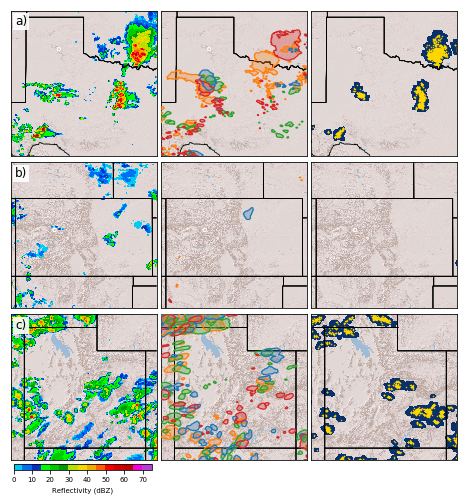

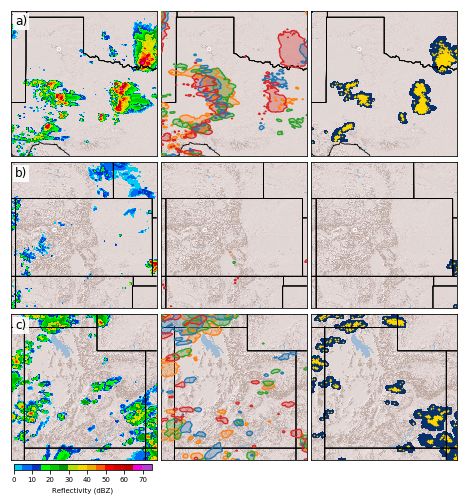

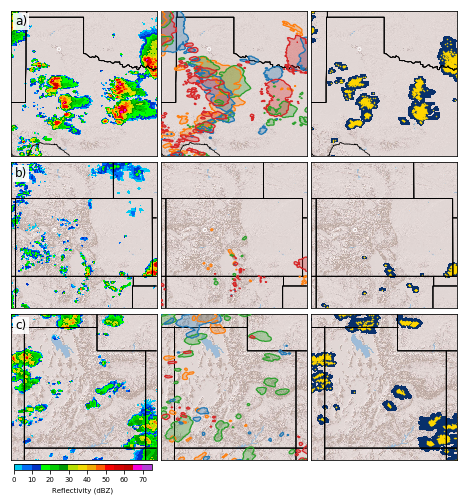

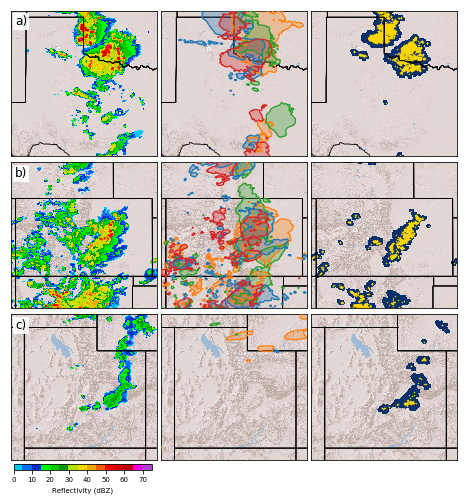

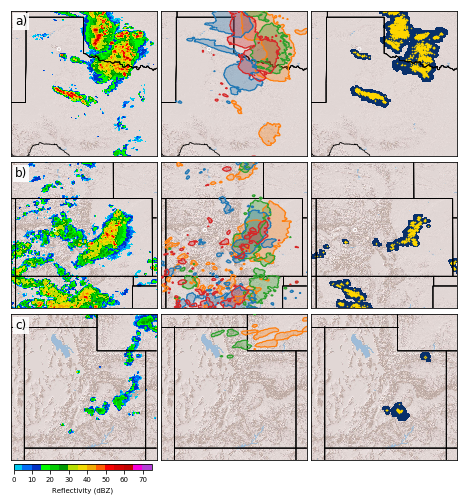

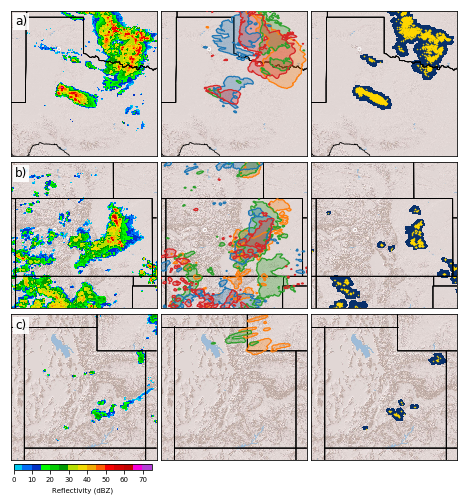

In [48]:
#dateoffset = [-3, -2, -1, 1, 2, 3]
dateoffset = [-6, -5, -4, 4, 5, 6]

for offset in dateoffset:
    fig, axes = plt.subplots(3,3, figsize=[8, 8.7])
    for ax, event, label, m in zip(axes, events, ['a)', 'b)', 'c)'], [mTexas, mColorado, mUtah]):
        FIRE = get_fire(event)
        DATE = FIRE['event']+timedelta(hours=offset)
        LON = FIRE['longitude']
        LAT = FIRE['latitude']

        for a in ax:
            plt.sca(a)
            m.drawstates()

        binary = get_GLM_HRRR_contingency_stats(DATE)

        # Left Figure: HRRR F00 Simulated Reflectivity
        pr = plot_refc(ax[0], DATE)

        # Center Figure: Select HRRR LTNG Forecasts
        plot_ltng(ax[1], DATE, binary)

        # Right Figure: GLM Events and Flashes
        plot_glm(ax[2], DATE, binary)

        print("Fishished:", event)

        # figure labels
        bbox = {'facecolor':'white',
                'alpha':0.90,
                'pad':2,
                'edgecolor':'none'}
        ax[0].set_title(label, position=(.07,.86), bbox=bbox, fontsize=12)

    # Colorbar (lost of custome tweeking for different figure sizes, ugh!)
    fig.subplots_adjust(bottom=0.01)
    cbar_ax = fig.add_axes([0.13, 0.07, 0.24, 0.01]) # [left-right, up-down, width, height]
    fig.colorbar(pr, cax=cbar_ax, orientation='horizontal', label='Reflectivity (dBZ)')

    fig.subplots_adjust(hspace=-.37, wspace=0.03)

    plt.savefig('./figs/Fig-04_Cases-Map_HOUR%s' % offset)

## May 2019 Case Study

>>> get_GLM_HRRR_contingency_stats: 2019-05-07 12:00:00
>>Load binary stats from file /uufs/chpc.utah.edu/common/home/horel-group8/blaylock/GLM-HRRR_LTNG_binary//HRRR-GLM-Binary_2019-05-07_1200.npy


/uufs/chpc.utah.edu/common/home/u0553130/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


Requested 2019-05-07 11:30:00	satellite: GOES-17	Product: GLM
Requested 2019-05-07 11:30:00	satellite: GOES-16	Product: GLM
-->> Accumulate GLM FAST MP: 90.0%Fishished: May Storm
>>> get_GLM_HRRR_contingency_stats: 2019-05-07 13:00:00
>>Load binary stats from file /uufs/chpc.utah.edu/common/home/horel-group8/blaylock/GLM-HRRR_LTNG_binary//HRRR-GLM-Binary_2019-05-07_1300.npy
Requested 2019-05-07 12:30:00	satellite: GOES-17	Product: GLM
-->> Accumulate GLM FAST MP: 75.0%Requested 2019-05-07 12:30:00	satellite: GOES-16	Product: GLM
-->> Accumulate GLM FAST MP: 80.0%Fishished: May Storm
>>> get_GLM_HRRR_contingency_stats: 2019-05-07 14:00:00
>>Load binary stats from file /uufs/chpc.utah.edu/common/home/horel-group8/blaylock/GLM-HRRR_LTNG_binary//HRRR-GLM-Binary_2019-05-07_1400.npy
Requested 2019-05-07 13:30:00	satellite: GOES-17	Product: GLM
-->> Accumulate GLM FAST MP: 70.0%Requested 2019-05-07 13:30:00	satellite: GOES-16	Product: GLM
Fishished: May Storm
>>> get_GLM_HRRR_contingency_stat

/uufs/chpc.utah.edu/common/home/u0553130/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


>>> get_GLM_HRRR_contingency_stats: 2019-05-08 08:00:00
>>Load binary stats from file /uufs/chpc.utah.edu/common/home/horel-group8/blaylock/GLM-HRRR_LTNG_binary//HRRR-GLM-Binary_2019-05-08_0800.npy
-->> Accumulate GLM FAST MP: 80.0%      1,230,474 events in HRRR
         11,654 events in West
      1,212,524 events in Central
          6,294 events in East
          2,835 events in Utah
          4,355 events in Colorado
        517,282 events in Texas
              6 events in Florida
Requested 2019-05-08 07:30:00	satellite: GOES-17	Product: GLM
-->> Accumulate GLM FAST MP: 65.0%Requested 2019-05-08 07:30:00	satellite: GOES-16	Product: GLM
Fishished: May Storm
>>> get_GLM_HRRR_contingency_stats: 2019-05-08 09:00:00
>>Load binary stats from file /uufs/chpc.utah.edu/common/home/horel-group8/blaylock/GLM-HRRR_LTNG_binary//HRRR-GLM-Binary_2019-05-08_0900.npy
-->> Accumulate GLM FAST MP: 30.0%      1,292,124 events in HRRR
          2,049 events in West
      1,258,168 events in Central
  

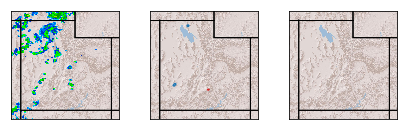

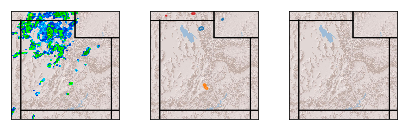

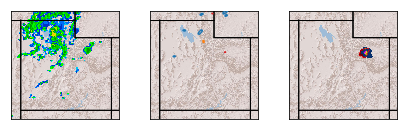

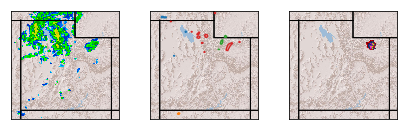

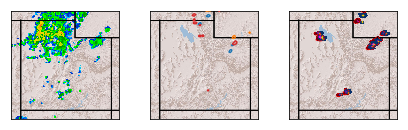

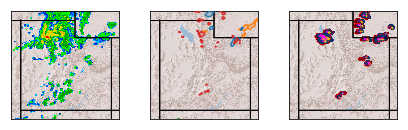

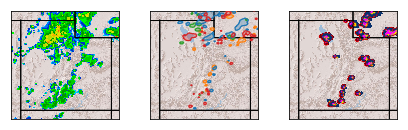

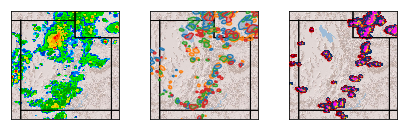

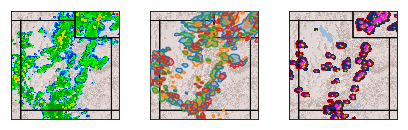

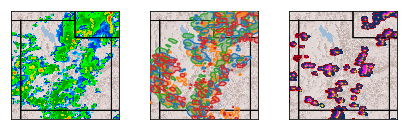

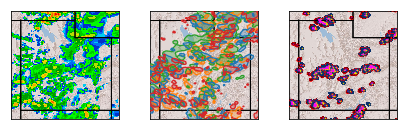

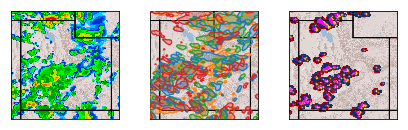

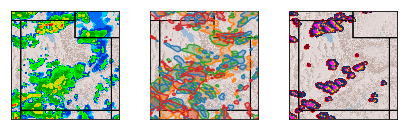

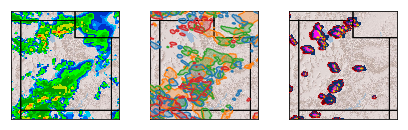

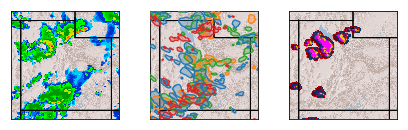

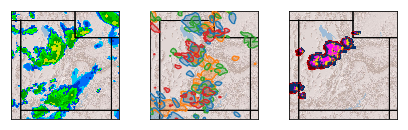

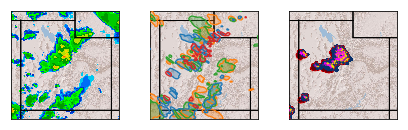

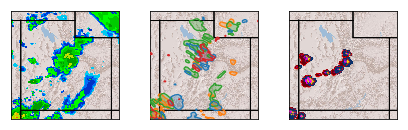

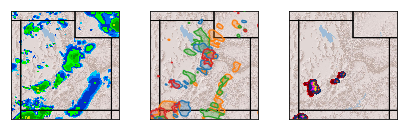

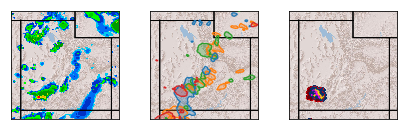

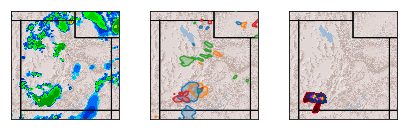

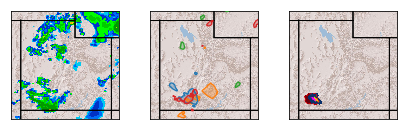

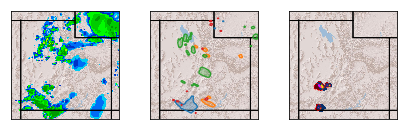

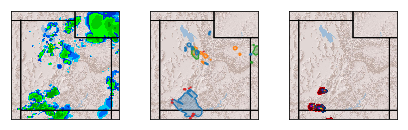

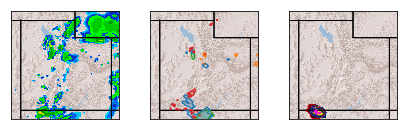

In [11]:
sDATE = datetime(2019, 5, 7, 12)
eDATE = datetime(2019, 5, 8, 13)
hours = int((eDATE-sDATE).days*24 + (eDATE-sDATE).seconds/60/60)
DATES = [sDATE+timedelta(hours=h) for h in range(hours)]

for DATE in DATES:
    fig, axes = plt.subplots(1,3, figsize=[7.4, 2.])
    figsize=[7.4, 2.]
    m = mUtah
    label = ''
    event = 'May Storm'
    domain = 'Utah'
    NAME = ['May 2019 Storm']
    ax = axes
    #FIRE = get_fire(event)
    #DATE = FIRE['event']+timedelta(hours=offset)
    #LON = FIRE['longitude']
    #LAT = FIRE['latitude']

    for a in ax:
        plt.sca(a)
        m.drawstates()

    binary = get_GLM_HRRR_contingency_stats(DATE)

    # Left Figure: HRRR F00 Simulated Reflectivity
    pr = plot_refc(ax[0], DATE)

    # Center Figure: Select HRRR LTNG Forecasts
    plot_ltng(ax[1], DATE, binary)

    # Right Figure: GLM Events and Flashes
    plot_glm(ax[2], DATE, binary, GOES17=True, verbose=False)

    print("Fishished:", event)

    # figure labels
    #bbox = {'facecolor':'white',
    #        'alpha':0.90,
    #        'pad':2,
    #        'edgecolor':'none'}
    #ax[0].set_title(label, position=(.07,.86), bbox=bbox, fontsize=12)

    # Colorbar (lost of custome tweeking for different figure sizes, ugh!)
    #fig.subplots_adjust(bottom=0.01)
    #cbar_ax = fig.add_axes([0.13, 0.07, 0.24, 0.01]) # [left-right, up-down, width, height]
    #fig.colorbar(pr, cax=cbar_ax, orientation='horizontal', label='Reflectivity (dBZ)')

    fig.subplots_adjust(hspace=-.37, wspace=0.03)

    plt.savefig('./figs/May2019/not_shown_Cases-Map_%s' % DATE.strftime('%Y%m%d_%H%M'))